

<center><img src="https://cdn-icons-png.freepik.com/512/4297/4297975.png" width=150 height=150 /></center>

# The Pythagorean Expectation

"Pythagorean expectation is a sports analytics formula devised by Bill James to estimate the percentage of games a baseball team "should" have won based on the number of runs they scored and allowed. Comparing a team's actual and Pythagorean winning percentage can be used to make predictions and evaluate which teams are over-performing and under-performing. The name comes from the formula's resemblance to the Pythagorean theorem."

The basic formula is:



### $${\rm Win\  Ratio} = {\frac{{\rm runs\ scored\ ²} }{{\rm runs\ scored\ ² + runs\ allowed\ ²}}} = {\frac{{\rm 1} }{{\rm 1 + (runs\ allowed\  / \ runs\ scored)\ ²}}}$$
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

Where **runs scored** is runs/points/goals scored and **runs allowed** is runs/points/goals conceded.

<br> 


**Goal:**

The goal of this analysis is to apply **Pythagorean Expectation** to predict which teams will under/overperform on the second half o the season. I am not going to focus on the details of all match statistics. Just on the Pythagorean Expectation analysis

<br> 

**League:**

I am going to focus on the English football league **Premier League**. Specifically  on the last season that started at: 11/08/2023 and ended date: 19/05/2024.


"The Premier League is the highest level of the English football league system. Contested by 20 clubs, it operates on a system of promotion and relegation with the English Football League (EFL). Seasons usually run from August to May, with each team playing 38 matches: two against each other, one home and one away. Most games are played on weekend afternoons, with occasional weekday evening fixtures."


## Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pyodbc

## Import data

In [2]:
# String connection soccer database (local)

cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=DANILO;"
                      "Database=SoccerDB;"
                      "Trusted_Connection=yes;")
crsr = cnxn.cursor()

crsr.fast_executemany = True

In [3]:
# Query database with the data just for the scope of this analysis

matchstats_query = """SELECT  fixture_id,
                               team_id,
                                location,
                               stats_value
                        FROM dbo.Matchstatistics 
                        WHERE stats_name = 'goals'
                    """

fixtures_query = """SELECT id fixture_id,
                         round_id,
                           league_id,
                           season_id,
                           name teams_name,
                           starting_at
                    FROM dbo.Fixture
                    """

teams_query = """SELECT id team_id,
                        name team_name
                 FROM dbo.Teams
              """

leagues_query = """select id league_id,
                           name league_name
                    FROM leagues
                    WHERE active = 1
                """

seasons_query = """
                    select id season_id,
                           league_id,
                           name season_name
                    FROM seasons
                """

rounds_query = """
                SELECT id round_id,
                       name round_name,
                       starting_at,
                       ending_at
                FROM rounds
                """

In [4]:
# fetch tables and convert to pandas dataframe
stats = pd.read_sql(matchstats_query, cnxn)
fixtures = pd.read_sql(fixtures_query, cnxn)
teams = pd.read_sql(teams_query, cnxn)
leagues = pd.read_sql(leagues_query, cnxn)
seasons = pd.read_sql(seasons_query, cnxn)
rounds = pd.read_sql(rounds_query, cnxn)

pd.set_option('display.max_columns', None)

## Gather basic Information

In [5]:
# Data Size
print(f'Stats\nRows: {stats.shape[0]} \nCols: {stats.shape[1]}\n')
print(f'Matches\nRows: {fixtures.shape[0]} \nCols: {fixtures.shape[1]}\n')
print(f'Teams\nRows: {teams.shape[0]} \nCols: {teams.shape[1]}\n')
print(f'Leagues\nRows: {leagues.shape[0]} \nCols: {leagues.shape[1]}\n')
print(f'Seasons\nRows: {seasons.shape[0]} \nCols: {seasons.shape[1]}\n')

Stats
Rows: 937751 
Cols: 4

Matches
Rows: 639888 
Cols: 6

Teams
Rows: 58843 
Cols: 2

Leagues
Rows: 2125 
Cols: 2

Seasons
Rows: 14345 
Cols: 3



In [6]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937751 entries, 0 to 937750
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   fixture_id   937751 non-null  int64  
 1   team_id      937751 non-null  int64  
 2   location     937751 non-null  object 
 3   stats_value  937524 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 28.6+ MB


In [7]:
stats.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
fixture_id,937751.0,18778207.96,231504.74,11989550.0,18579379.5,18835660.0,18961458.5,19126224.0
team_id,937751.0,111090.94,116076.31,1.0,6893.0,26480.0,248187.0,272952.0
stats_value,937524.0,1.52,1.53,0.0,0.0,1.0,2.0,42.0


In [8]:
stats[stats.duplicated()]

,fixture_id,team_id,location,stats_value


In [9]:
stats.isna().sum()

fixture_id       0
team_id          0
location         0
stats_value    227
dtype: int64

In [10]:
fixtures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639888 entries, 0 to 639887
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   fixture_id   639888 non-null  int64         
 1   round_id     528464 non-null  float64       
 2   league_id    639888 non-null  int64         
 3   season_id    639888 non-null  int64         
 4   teams_name   639888 non-null  object        
 5   starting_at  639888 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 29.3+ MB


In [11]:
fixtures.describe().T.round(2)

,count,mean,min,25%,50%,75%,max,std
fixture_id,639888.0,18737780.252935,11989550.0,18570396.75,18749456.5,18925301.25,19126224.0,227350.760218
round_id,528464.0,295703.883754,186733.0,277832.75,295822.0,315076.0,338445.0,22932.648762
league_id,639888.0,1675.650414,2.0,989.0,1684.0,2497.0,3364.0,912.134143
season_id,639888.0,20832.498042,15721.0,19828.0,20726.0,21967.0,23525.0,1302.680621
starting_at,639888,2023-04-09 05:33:11.737490944,2022-01-01 06:05:00,2022-09-17 12:30:00,2023-04-15 00:22:30,2023-11-04 15:00:00,2024-05-20 23:30:00,NaN


In [12]:
fixtures[fixtures.duplicated()]

,fixture_id,round_id,league_id,season_id,teams_name,starting_at
712,18452320,NaN,705,18411,Comunicaciones vs Malacateco,2022-01-03 02:00:00
713,18453143,265178.0,1344,19097,Himalayan Sherpa vs Satdobato,2022-01-03 07:15:00
714,18451856,265036.0,989,18238,Wuhan Zall vs Chongqing Dangdai Lifan,2022-01-03 07:30:00
715,18451857,265036.0,989,18238,Tianjin Teda vs Shijiazhuang Ever Bright,2022-01-03 07:30:00
716,18451858,265036.0,989,18238,Dalian Professional vs Qingdao Hainiu,2022-01-03 07:30:00
...,...,...,...,...,...,...
54123,18466922,NaN,791,19268,Birmingham Legion vs Louisville City,2022-04-02 23:30:00
54124,18469569,267155.0,1098,19355,Club Universitario vs Atlético Palmaflor,2022-04-02 23:30:00
54125,18488015,268455.0,666,19428,San Luis vs Copiapó,2022-04-02 23:30:00
54126,18488020,268455.0,666,19428,Recoleta vs Rangers,2022-04-02 23:30:00


In [13]:
fixtures.isna().sum()

fixture_id          0
round_id       111424
league_id           0
season_id           0
teams_name          0
starting_at         0
dtype: int64

In [14]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58843 entries, 0 to 58842
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   team_id    58843 non-null  int64 
 1   team_name  58843 non-null  object
dtypes: int64(1), object(1)
memory usage: 919.5+ KB


In [15]:
teams.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
team_id,58843.0,180209.66,106088.57,1.0,28930.5,243278.0,258224.5,272958.0


In [16]:
teams[teams.duplicated()]

,team_id,team_name


In [17]:
leagues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2125 entries, 0 to 2124
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   league_id    2125 non-null   int64 
 1   league_name  2125 non-null   object
dtypes: int64(1), object(1)
memory usage: 33.3+ KB


In [18]:
leagues.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
league_id,2125.0,1986.9,903.92,2.0,1327.0,1954.0,2785.0,3370.0


In [19]:
leagues[leagues.duplicated()]

,league_id,league_name


In [20]:
seasons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14345 entries, 0 to 14344
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   season_id    14345 non-null  int64 
 1   league_id    14345 non-null  int64 
 2   season_name  14345 non-null  object
dtypes: int64(2), object(1)
memory usage: 336.3+ KB


In [21]:
seasons.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
season_id,14345.0,12569.19,8124.39,1.0,4005.0,15946.0,19932.0,23561.0
league_id,14345.0,1264.30,802.87,2.0,639.0,1213.0,1662.0,3371.0


In [22]:
seasons[seasons.duplicated()]

,season_id,league_id,season_name


In [23]:
seasons.isna().sum()

season_id      0
league_id      0
season_name    0
dtype: int64

In [24]:
rounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300260 entries, 0 to 300259
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   round_id     300260 non-null  int64 
 1   round_name   300260 non-null  object
 2   starting_at  273613 non-null  object
 3   ending_at    273613 non-null  object
dtypes: int64(1), object(3)
memory usage: 9.2+ MB


In [25]:
rounds.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
round_id,300260.0,164370.62,101311.08,1.0,76014.75,155192.5,261023.25,338619.0


In [26]:
rounds[rounds.duplicated()]

,round_id,round_name,starting_at,ending_at


# Data Prep

## Season 2022/2023 Premier League

In [27]:
# Drop duplicated matches
fixtures = fixtures.drop_duplicates(keep='first')

In [28]:
# filter matches from season 2022/2023 Premier League
fixtures_premier = fixtures[fixtures['season_id'] == 21646] 

In [29]:
# split the data into home and away games
home = stats[['fixture_id','team_id','stats_value']][stats['location']=='home']
away = stats[['fixture_id','team_id','stats_value']][stats['location']=='away']

In [30]:
# joining tables
home_all = (home.merge(fixtures_premier, left_on='fixture_id', right_on='fixture_id')
                 .merge(teams, left_on='team_id', right_on='team_id')
                 .merge(rounds, left_on='round_id', right_on='round_id')
                )
                  

away_all = (away.merge(fixtures_premier, left_on='fixture_id', right_on='fixture_id')
             .merge(teams, left_on='team_id', right_on='team_id')
             .merge(rounds, left_on='round_id', right_on='round_id')
            )

all_games = home_all.merge(away_all, on='fixture_id')

In [31]:
cols = ['fixture_id','round_name_x', 'starting_at_y_x', 'teams_name_x', 'team_name_x', \
        'stats_value_x','team_name_y', 'stats_value_y' ]

In [32]:
all_games = all_games[cols].rename(columns={'round_name_x':'round','starting_at_y_x':'date','teams_name_x':'match_name',\
                                            'team_name_x':'home_team','stats_value_x':'home_goals','team_name_y':'away_team',\
                                            'stats_value_y':'away_goals'})

In [33]:
all_games.head(2)

,fixture_id,round,date,match_name,home_team,home_goals,away_team,away_goals
0,18841616,1,2023-08-11,Burnley vs Manchester City,Burnley,0.0,Manchester City,3.0
1,18841617,1,2023-08-11,Arsenal vs Nottingham Forest,Arsenal,2.0,Nottingham Forest,1.0


## Data Prep Pythagorean Expectation (First Half of the Season)

### Filter rounds from 1 to 19 (half season)

In [34]:
half_season = all_games[all_games['round'].astype(int) <= 19]

In [35]:
# indicates if the team won when was playing home
half_season['home_win'] = [1 if  h > v else 0.5 if h == v else 0  \
                           for h, v in zip(half_season['home_goals'],half_season['away_goals'])]


# indicates if the team won when was playing away
half_season['away_win'] = [1 if  v > h  else 0.5 if h == v else 0   \
                           for h, v in zip(half_season['home_goals'], half_season['away_goals'])]

half_season['count'] = 1

In [36]:
# Points System
WIN = 3
DRAW = 1

In [37]:
# Calculate the number of points playing home
half_season['home_points'] = [WIN if h > a else DRAW if h ==  a else 0 \
                              for h, a in zip(half_season['home_win'], half_season['away_win'])] 

In [38]:
# Calculate the number of points playing away
half_season['away_points'] = [WIN if a > h else DRAW if a ==  h else 0 \
                              for h, a in zip(half_season['home_win'], half_season['away_win'])] 

In [39]:
# Summarize total matches won at home and total goals
home_team = (half_season[['home_team','home_win','home_goals','away_goals','home_points','count']]
                 .groupby(['home_team'])
                 .sum()
                 .reset_index()
                 .rename(columns={'home_team': 'team', 'count':'Ph', 'home_goals':'FTHGh','away_goals':'FTAGh' })
            )

In [40]:
# Summarize total matches won away and total goals
away_team = (half_season[['away_team','away_win','away_goals','home_goals','away_points','count']]
                 .groupby(['away_team'])
                 .sum()
                 .reset_index()
                 .rename(columns={'away_team': 'team', 'count':'Pa','away_goals':'FTAGa', 'home_goals':'FTHGa'})
            )

In [41]:

# Summarize total wins home
total_home_win = (half_season[['home_team', 'home_win']][half_season['home_win'] == 1]
                        .groupby('home_team')
                        .count()
                        .reset_index()
                    )
# Summarize total lost home
total_home_lost = (half_season[['home_team', 'home_win']][half_season['home_win'] == 0]
                        .groupby('home_team')
                        .count()
                        .reset_index()
                    )

# Summarize total draw home
total_home_draw = (half_season[['home_team', 'home_win']][half_season['home_win'] == 0.5]
                        .groupby('home_team')
                        .count()
                        .reset_index()
                    )

In [42]:
# Summarize total draw away
total_away_win = (half_season[['away_team', 'away_win']][half_season['away_win'] == 1]
                        .groupby('away_team')
                        .count()
                        .reset_index()
                    )
# Summarize total draw away
total_away_lost = (half_season[['away_team', 'away_win']][half_season['away_win'] == 0]
                        .groupby('away_team')
                        .count()
                        .reset_index()
                    )
# Summarize total draw away
total_away_draw = (half_season[['away_team', 'away_win']][half_season['away_win'] == 0.5]
                        .groupby('away_team')
                        .count()
                        .reset_index()
                    )

In [43]:
# Summary table home
table_home = (total_home_win.merge(total_home_lost, how='left', on='home_team')
                                     .merge(total_home_draw, how='left', on='home_team')
                    ).rename(columns={'home_team':'Team', 'home_win_x':'Home_Win','home_win_y':'Home_Lost',\
                                      'home_win':'Home_Draw'}).fillna(0)

In [44]:
# Summary table home
table_away = (total_away_win.merge(total_away_lost, how='right', on='away_team')
                                      .merge(total_away_draw, how='right', on='away_team')
                     ).rename(columns={'away_team':'Team', 'away_win_x':'Away_Win','away_win_y':'Away_Lost',\
                                       'away_win':'Away_Draw'}).fillna(0)

In [45]:
# Joining summary tables
total_matches = table_home.merge(table_away, how='left', on='Team')

In [46]:
# Totals
total_matches['total_win']  = (total_matches['Home_Win'] + total_matches['Away_Win']).astype(int)
total_matches['total_lost'] = (total_matches['Home_Lost'] + total_matches['Away_Lost']).astype(int)
total_matches['total_draw'] = (total_matches['Home_Draw'] + total_matches['Away_Draw']).astype(int)

In [47]:
# joining matches summary
summary_half_season = (away_team.merge(home_team, left_on='team', right_on='team')
                       )

In [48]:
summary_half_season['total_points'] = summary_half_season['home_points'] + summary_half_season['away_points']

In [49]:
summary_half_season.head()

,team,away_win,FTAGa,FTHGa,away_points,Pa,home_win,FTHGh,FTAGh,home_points,Ph,total_points
0,AFC Bournemouth,4.5,16.0,20.0,13,9,5.5,15.0,15.0,15,10,28
1,Arsenal,6.0,14.0,8.0,17,9,8.0,22.0,10.0,23,10,40
2,Aston Villa,5.0,14.0,19.0,14,10,8.5,26.0,6.0,25,9,39
3,Brentford,2.5,8.0,11.0,7,9,4.5,17.0,18.0,12,10,19
4,Brighton & Hove Albion,4.0,16.0,19.0,11,9,7.0,22.0,14.0,19,10,30


## Pythagorean Expectation

In [50]:
# Calculate Total wins, games, played, goals for and goals against (home team and away team
summary_half_season['W']=summary_half_season['home_win']+summary_half_season['away_win']
summary_half_season['G']=summary_half_season['Ph']+summary_half_season['Pa']
summary_half_season['GF']=summary_half_season['FTHGh']+summary_half_season['FTAGa']
summary_half_season['GA']=summary_half_season['FTAGh']+summary_half_season['FTHGa']
summary_half_season.head(2)

,team,away_win,FTAGa,FTHGa,away_points,Pa,home_win,FTHGh,FTAGh,home_points,Ph,total_points,W,G,GF,GA
0,AFC Bournemouth,4.5,16.0,20.0,13,9,5.5,15.0,15.0,15,10,28,10.0,19,31.0,35.0
1,Arsenal,6.0,14.0,8.0,17,9,8.0,22.0,10.0,23,10,40,14.0,19,36.0,18.0


In [51]:
# Calculate the percentage of win and pythagorean expectation
summary_half_season['wpc'] = summary_half_season['W']/summary_half_season['G']

summary_half_season['pyth'] = summary_half_season['GF']**2/(summary_half_season['GF']**2 + summary_half_season['GA']**2)
summary_half_season.head(2)

,team,away_win,FTAGa,FTHGa,away_points,Pa,home_win,FTHGh,FTAGh,home_points,Ph,total_points,W,G,GF,GA,wpc,pyth
0,AFC Bournemouth,4.5,16.0,20.0,13,9,5.5,15.0,15.0,15,10,28,10.0,19,31.0,35.0,0.526316,0.439616
1,Arsenal,6.0,14.0,8.0,17,9,8.0,22.0,10.0,23,10,40,14.0,19,36.0,18.0,0.736842,0.800000


# Exploratory Data Analysis

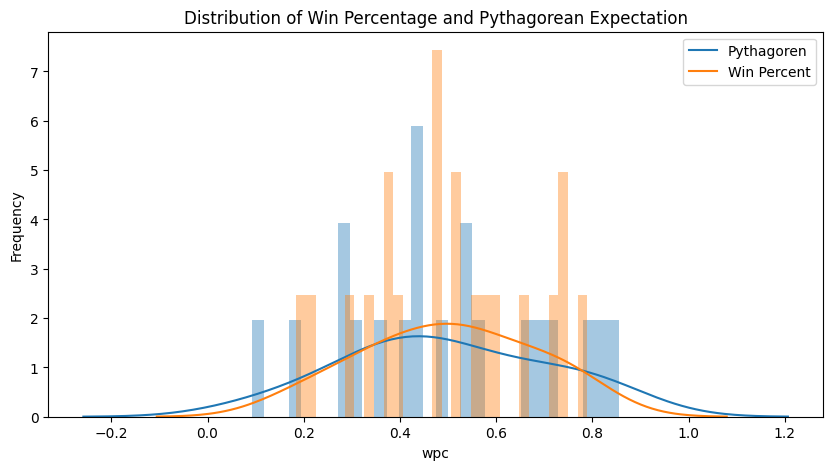

In [52]:

plt.figure(figsize=(10,5))
plt.title('Distribution of Win Percentage and Pythagorean Expectation')
plt.xlabel('Percentage')
plt.ylabel('Frequency')
sns.distplot(summary_half_season['pyth'], bins= 30)
sns.distplot(summary_half_season['wpc'], bins=30)
plt.legend(['Pythagoren', 'Win Percent']);


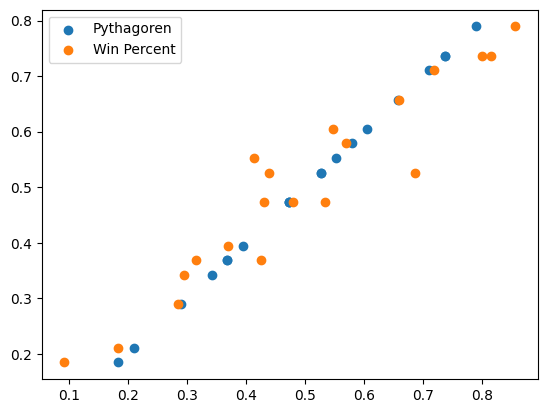

In [53]:
plt.scatter(summary_half_season['wpc'],summary_half_season['wpc'])
plt.scatter(summary_half_season['pyth'], summary_half_season['wpc'])

plt.legend(['Pythagoren', 'Win Percent']);


Correlation: 0.952


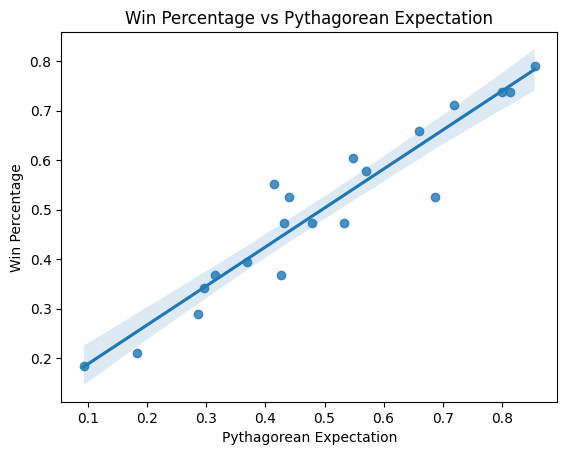

In [54]:
sns.regplot(data=summary_half_season,
               x = 'pyth',
               y= 'wpc'
              )
plt.xlabel('Pythagorean Expectation')
plt.ylabel('Win Percentage')
plt.title('Win Percentage vs Pythagorean Expectation')

print(f"Correlation: {summary_half_season['pyth'].corr(summary_half_season['wpc']).round(3)}")

## Evaluating the results running a regression analysis

In [55]:
# Run the regression
pyth_lm = smf.ols(formula = 'wpc ~ pyth', data=summary_half_season).fit()
pyth_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wpc   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     175.0
Date:                Thu, 01 Aug 2024   Prob (F-statistic):           1.03e-10
Time:                        14:00:08   Log-Likelihood:                 30.626
No. Observations:                  20   AIC:                            -57.25
Df Residuals:                      18   BIC:                            -55.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1097      0.032      3.429      0.003       0.042       0.177
pyth           0.7872      0.059     13.230      0.000       0.662       0.912
==============================================================================
Omnibus:                        1.320   Durbin-Watson:                   2.483
Prob(Omnibus):                  0.517   Jarque-Bera (JB):                0.245
Skew:                          -0.130   Prob(JB):                        0.885
Kurtosis:                       3.477   Cond. No.                         6.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<center><img src="https://i.ibb.co/MB4VJzZ/bulb.png" width=100 height=100/></center>

1. **The histogram** showed a similar distribution between the Win percentage and Pythagorean Expectation. 

<br>

2. **The scatterplot** with the regression line showed a positive linear relationship between Win percentage and Pythagorean Expectation with a Pearson's Correlation of 0.952

<br>

3. **The Regression resuls** resulted in a R² of 0.907 for explained variance between the percentage and Pythagorean Expectation with a p-value smaller than 0.05 . Intercept 0.1097, slope 0.782 indicating a very close relationship.

# Results

In [56]:
# Calculate the difference between expected and actual
summary_half_season['total_wins'] = summary_half_season['G'] * summary_half_season['pyth']

In [57]:
# Calculate the difference between expected and actual
summary_half_season['expected_wins'] = summary_half_season['G'] * summary_half_season['pyth']

In [58]:
# Calculate wins above/below expected
summary_half_season['wins_above_expected'] = summary_half_season['W'] -  summary_half_season['expected_wins']

In [59]:
summary_half_season = summary_half_season.merge(total_matches[['Team','total_win','total_lost','total_draw']], \
                                                left_on='team', right_on='Team')

In [60]:
cols = ['team', 'total_points','wpc','pyth','W','expected_wins', 'wins_above_expected', 'total_win', 'total_lost','total_draw']

In [61]:
# Creating table results
table_first_half = (summary_half_season[cols]
        .sort_values('W', ascending=False)
)

table_first_half.index = np.arange(1, len(table_first_half)+1)

table_first_half.columns = ['Team', 'Total Points', 'Win Percentage',' Pythagorean Expectation', 'Wins/Draw', 'Expected Wins',\
                           'Wins Above/Below Expected', 'Total Win', 'Total Lost','Total Draw']

In [62]:
table_first_half.style.background_gradient(axis=0, subset=['Wins Above/Below Expected'])

,Team,Total Points,Win Percentage,Pythagorean Expectation,Wins/Draw,Expected Wins,Wins Above/Below Expected,Total Win,Total Lost,Total Draw
1,Liverpool,42,0.789474,0.855937,15.000000,16.262802,-1.262802,12,1,6
2,Arsenal,40,0.736842,0.800000,14.000000,15.200000,-1.200000,12,3,4
3,Manchester City,40,0.736842,0.814472,14.000000,15.474968,-1.474968,12,3,4
4,Aston Villa,39,0.710526,0.719101,13.500000,13.662921,-0.162921,12,4,3
5,Tottenham Hotspur,36,0.657895,0.659870,12.500000,12.537527,-0.037527,11,5,3
6,West Ham United,33,0.605263,0.547511,11.500000,10.402715,1.097285,10,6,3
7,Brighton & Hove Albion,30,0.578947,0.570075,11.000000,10.831425,0.168575,8,5,6
8,Manchester United,31,0.552632,0.413696,10.500000,7.860225,2.639775,10,8,1
9,Newcastle United,29,0.526316,0.686560,10.000000,13.044634,-3.044634,9,8,2
10,AFC Bournemouth,28,0.526316,0.439616,10.000000,8.352699,1.647301,8,7,4


<center><img src="https://i.ibb.co/MB4VJzZ/bulb.png" width=100 height=100/></center>

Considering `Manchester United` and `Newcastle United` that resulted in a more extreme difference.

`Manchester United`(8) resulted in 2.69 indicating that the team overperformed in the first half of the season. There is a signifcant chance that team will perform poorly on the second half of the season

`Newcastle United`(9) resulted in -3.04 indicating that the team underperformed in the first half of the season. There is a significant chance that the team will perform better on the second half of the season


It seems that the other teams are going to perform close to expected for the second half of the season. They are in a comfortable position.

# Results for the final season

Source: https://1x2stats.com/en-gb/ENG/2023/Premier-League/table/?da=2023-08-11&a=2024-05-19


    
<center><img src="https://i.ibb.co/BCWVff2/table-season.png" width=900 height=1100 /></center>

* ## Power BI Viz
### [Premier League Analysis](https://app.powerbi.com/view?r=eyJrIjoiOGRjMGMyNWEtMGExNS00MjAzLTk1MmYtMTk5YjZhZDhhMjk5IiwidCI6IjhkODQwNjdkLTlhZDctNDU3Mi05YjEwLTEzM2QzNjQ2MmFhYSIsImMiOjF9)


    
    

<center><img src="https://i.ibb.co/RCpybK6/2024-07-31-09-33-52-Sports-Data-Analysis-Power-BI.png" width=1000 height=1000 /></center>


    
    

<center><img src="https://i.ibb.co/R4FdjBb/2024-07-31-09-34-09-Sports-Data-Analysis-Power-BI.png" width=1000 height=1000 /></center>

# References:

**Sports Performance Analytics Specialization - University of Michigan**

https://www.coursera.org/specializations/sports-analytics


**Pythagorean Expectation**

https://en.wikipedia.org/wiki/Pythagorean_expectation

**Premier League**

https://en.wikipedia.org/wiki/Premier_League




<center><img src="https://cdn.prod.website-files.com/646218c67da47160c64a84d5/64634be786d11debe86c8c42_86.png" width=200 height=200 /></center>